In [5]:

import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader, Dataset
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
from asteroid.metrics import get_metrics
from asteroid.losses import singlesrc_neg_sisdr, singlesrc_neg_snr

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from IPython.display import Audio
from tqdm import tqdm
import time



def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid
    
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = {}

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations


class AudioFile(torch.utils.data.Dataset):
    def __init__(self, filename):
        self.data, self.rate = torchaudio.load(filename)
        self.data = self.data.transpose(-1,-2).numpy()[...,0]
        self.data = self.data.astype(np.float32)
        self.timepoints = get_mgrid(len(self.data), 1)

    def get_num_samples(self):
        return self.timepoints.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        amplitude = self.data
        scale = np.max(np.abs(amplitude))
        amplitude = (amplitude / scale)
        amplitude = torch.Tensor(amplitude).view(-1, 1)
        return self.timepoints, amplitude

In [114]:
def spectrogram(wav):
    stft = torchaudio.transforms.Spectrogram(n_fft=1024)(wav)[0]
    stft = torchaudio.transforms.AmplitudeToDB(top_db=80)(stft).numpy()
    stft = stft[::-1]
    fig = plt.figure(figsize=(20,10))
    im = plt.imshow(stft)
    plt.colorbar(im)

# bit = torchaudio.backend.sox_io_backend.info(os.path.join(datapath, 'all_mono.wav')).bits_per_sample
datapath = '/root/bigdatasets/INRcompression'
    
audio, rate = torchaudio.load(os.path.join(datapath, 'all_mono.wav'))
# for idx, i in enumerate(range(0, audio.shape[-1], rate * 10)):
#     torchaudio.save(os.path.join(datapath, f'all_mono_{idx}.wav'), audio[:, i:i+rate*10], sample_rate=rate)

wavpath = sorted(glob(os.path.join(datapath, f'all_mono_*.wav')), key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[-1]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:40<00:00, 19.95it/s, loss=0.00362]


4.090844631195068 1.8136804103851318 2.694513428211212
[2.1913037300109863, 4.090844631195068, 2.8505609035491943, 2.070871114730835, 3.0212457180023193, 1.819939374923706, 2.112136125564575, 3.649043083190918, 2.134927749633789, 2.740494728088379, 3.2083892822265625, 2.734362840652466, 3.1244330406188965, 3.3067872524261475, 3.1723709106445312, 2.133647918701172, 1.8412864208221436, 2.3237061500549316, 1.8136804103851318, 3.5502371788024902]


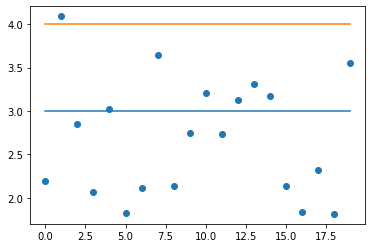

In [76]:
total_steps = 2000
steps_til_summary = 1000
lr = 1e-4
# schedule = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, 100, T_mult=1, eta_min=lr / 1000, last_epoch=- 1, verbose=False)
# decay = torch.optim.lr_scheduler.StepLR(optim, total_steps, (1 / 1000) ** (1 / total_steps))

pesq = []
for wave in wavpath:
    bach_audio = AudioFile(wave)

    audio_siren = Siren(in_features=1, out_features=1, hidden_features=256, 
                        hidden_layers=3, first_omega_0=3000, outermost_linear=True)
    audio_siren.cuda()
    dataloader = DataLoader(bach_audio, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)
    
    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

    model_input, ground_truth, audio_siren = model_input.type(torch.float64), \
                                            ground_truth.type(torch.float64), \
                                             audio_siren.type(torch.float64)
    optim = torch.optim.Adam(lr=lr, params=audio_siren.parameters())
    decay = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=1/2**0.5, patience=20, verbose=False)
    # optim = torch.optim.AdamW(lr=1e-4, params=audio_siren.parameters())
    
    minloss = torch.inf
    with tqdm(range(total_steps)) as pbar:
        for step in pbar:
            optim.zero_grad()
            model_output, coords = audio_siren(model_input)    
            loss = F.mse_loss(model_output, ground_truth)
            
            pbar.set_postfix({'loss': loss.item()})

            loss.backward()
            optim.step()
            # schedule.step(step)
            decay.step(loss.item())
            if step > int(total_steps * 0.9) and minloss >= loss.item():
                minloss = loss.item()
                best = audio_siren.state_dict()
    
    audio_siren.load_state_dict(best)
    audio_siren.eval()
    with torch.no_grad():
        model_output, _ = audio_siren(model_input)
        
    model_output = model_output.float()
    ground_truth = ground_truth.float()
    torchaudio.save(os.path.join(datapath, 'reduce_recons' + os.path.basename(wave)), model_output.squeeze(-1).cpu().float(), sample_rate=rate)
    model_output = torchaudio.functional.resample(model_output.squeeze(-1), rate, 16000).squeeze().cpu()
    model_input = torchaudio.functional.resample(model_input.squeeze(-1), rate, 16000).squeeze().cpu()
    
    # model_output, _ = torchaudio.load(os.path.join(datapath, 'recons' + os.path.basename(wave)))
    model_output = model_output.squeeze().numpy()
    ground_truth = torchaudio.functional.resample(ground_truth.squeeze(-1), rate, 16000).squeeze().cpu()
    pesq.append(get_metrics(model_output, ground_truth.numpy(), model_output, sample_rate=16000, metrics_list=['pesq'])['pesq'])

print(max(pesq), min(pesq), np.mean(pesq))
plt.scatter(np.arange(len(pesq)), pesq)
plt.plot(np.ones_like(pesq) * 3)
plt.plot(np.ones_like(pesq) * 4)
print(pesq)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:38<00:00, 20.21it/s, loss=0.00382]


4.163622856140137 1.6188592910766602 2.7103582859039306
[1.884674310684204, 4.163622856140137, 3.0302252769470215, 2.940239667892456, 3.6193439960479736, 2.122936487197876, 2.411799192428589, 3.4319839477539062, 2.364602565765381, 2.54945707321167, 3.163642644882202, 3.2269835472106934, 3.6859147548675537, 3.045039176940918, 2.505671501159668, 1.8204193115234375, 1.7328357696533203, 2.512073278427124, 1.6188592910766602, 2.3768410682678223]


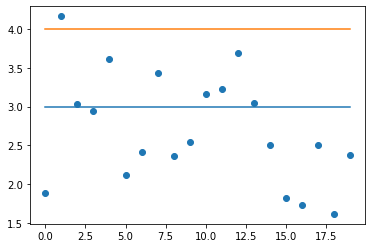

In [52]:
total_steps = 2000
steps_til_summary = 1000

pesq = []
for wave in wavpath:
    bach_audio = AudioFile(wave)

    audio_siren = Siren(in_features=1, out_features=1, hidden_features=256, 
                        hidden_layers=3, first_omega_0=3000, outermost_linear=True)
    audio_siren.cuda()
    dataloader = DataLoader(bach_audio, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)
    
    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

    model_input, ground_truth, audio_siren = model_input.type(torch.float64), \
                                            ground_truth.type(torch.float64), \
                                             audio_siren.type(torch.float64)
    optim = torch.optim.Adam(lr=1e-4, params=audio_siren.parameters())

    with tqdm(range(total_steps)) as pbar:
        for step in pbar:
            optim.zero_grad()
            model_output, coords = audio_siren(model_input)    
            loss = F.mse_loss(model_output, ground_truth)
            
            pbar.set_postfix({'loss': loss.item()})

            loss.backward()
            optim.step()
    
    audio_siren.eval()
    with torch.no_grad():
        model_output, _ = audio_siren(model_input)
        
    model_output = model_output.float()
    ground_truth = ground_truth.float()
    torchaudio.save(os.path.join(datapath, 'recons' + os.path.basename(wave)), model_output.squeeze(-1).cpu().float(), sample_rate=rate)
    model_output = torchaudio.functional.resample(model_output.squeeze(-1), rate, 16000).squeeze().cpu()
    model_input = torchaudio.functional.resample(model_input.squeeze(-1), rate, 16000).squeeze().cpu()
    
    # model_output, _ = torchaudio.load(os.path.join(datapath, 'recons' + os.path.basename(wave)))
    model_output = model_output.squeeze().numpy()
    ground_truth = torchaudio.functional.resample(ground_truth.squeeze(-1), rate, 16000).squeeze().cpu()
    pesq.append(get_metrics(model_output, ground_truth.numpy(), model_output, sample_rate=16000, metrics_list=['pesq'])['pesq'])

print(max(pesq), min(pesq), np.mean(pesq))
plt.scatter(np.arange(len(pesq)), pesq)
plt.plot(np.ones_like(pesq) * 3)
plt.plot(np.ones_like(pesq) * 4)
print(pesq)

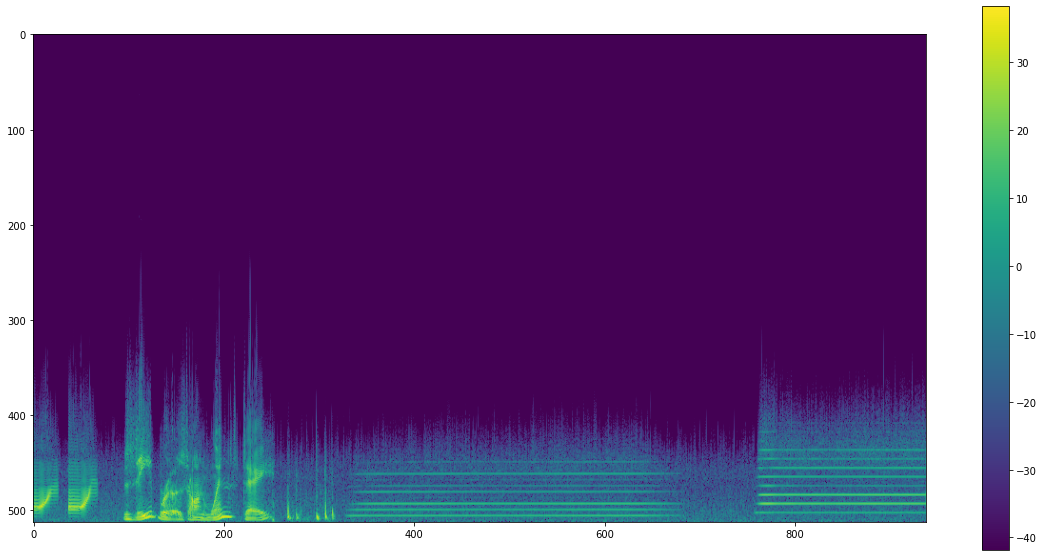

In [118]:
wav = torchaudio.load(os.path.join(datapath, 'recons' + os.path.basename(wavpath[-2])))[0]
spectrogram(wav)

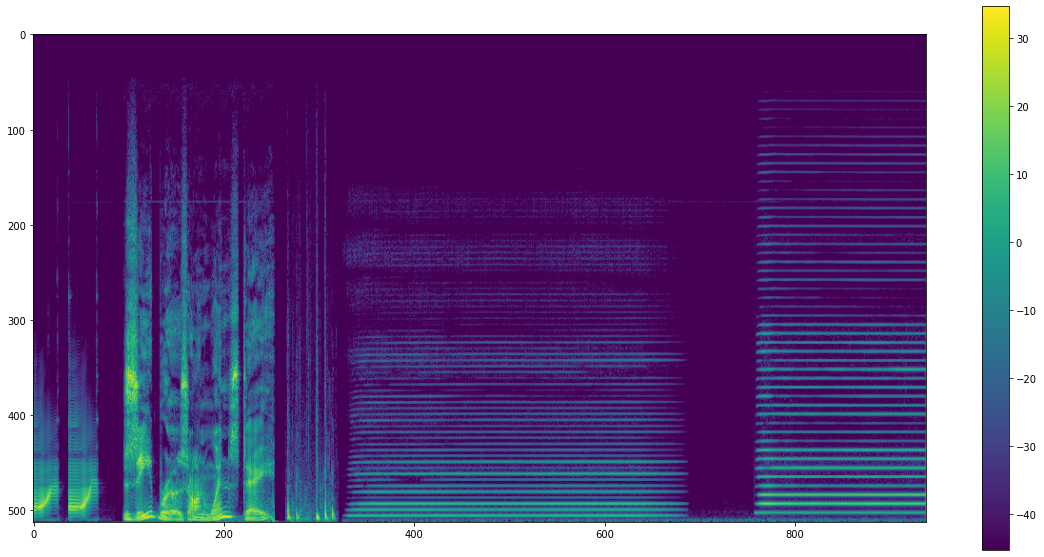

In [119]:
wav = torchaudio.load(os.path.join(datapath, os.path.basename(wavpath[-2])))[0]
spectrogram(wav)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:41<00:00, 19.68it/s, loss=-9.12]


3.6735832691192627 1.2472678422927856 1.8327788412570953
[1.3586972951889038, 3.6735832691192627, 2.943154811859131, 2.420450448989868, 2.0167336463928223, 1.2550081014633179, 1.6038157939910889, 1.6858973503112793, 1.3320527076721191, 1.8271019458770752, 1.652935266494751, 2.612362861633301, 2.519489049911499, 1.3918308019638062, 1.3325132131576538, 1.3354485034942627, 1.2472678422927856, 1.3866469860076904, 1.2550911903381348, 1.8054957389831543]


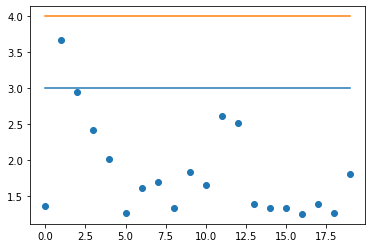

In [120]:
from asteroid.losses import singlesrc_neg_sisdr, singlesrc_neg_snr

total_steps = 2000
steps_til_summary = 1000
lr = 1e-4
# schedule = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, 100, T_mult=1, eta_min=lr / 1000, last_epoch=- 1, verbose=False)
# decay = torch.optim.lr_scheduler.StepLR(optim, total_steps, (1 / 1000) ** (1 / total_steps))

pesq = []
for wave in wavpath:
    bach_audio = AudioFile(wave)

    audio_siren = Siren(in_features=1, out_features=1, hidden_features=256, 
                        hidden_layers=3, first_omega_0=3000, outermost_linear=True)
    audio_siren.cuda()
    dataloader = DataLoader(bach_audio, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)
    
    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

    model_input, ground_truth, audio_siren = model_input.type(torch.float64), \
                                            ground_truth.type(torch.float64), \
                                             audio_siren.type(torch.float64)
    optim = torch.optim.Adam(lr=lr, params=audio_siren.parameters())
    decay = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=1/2**0.5, patience=20, verbose=False)
    # optim = torch.optim.AdamW(lr=1e-4, params=audio_siren.parameters())
    
    minloss = torch.inf
    with tqdm(range(total_steps)) as pbar:
        for step in pbar:
            optim.zero_grad()
            model_output, coords = audio_siren(model_input)    
            # loss = F.mse_loss(model_output, ground_truth)
            loss = singlesrc_neg_sisdr(model_output.squeeze(-1), ground_truth.squeeze(-1))
            
            pbar.set_postfix({'loss': loss.item()})

            loss.backward()
            optim.step()
            # schedule.step(step)
            decay.step(loss.item())
            if step > int(total_steps * 0.9) and minloss >= loss.item():
                minloss = loss.item()
                best = audio_siren.state_dict()
    
    audio_siren.load_state_dict(best)
    audio_siren.eval()
    with torch.no_grad():
        model_output, _ = audio_siren(model_input)
        
    model_output = model_output.float()
    ground_truth = ground_truth.float()
    torchaudio.save(os.path.join(datapath, 'SISNR_recons' + os.path.basename(wave)), model_output.squeeze(-1).cpu().float(), sample_rate=rate)
    model_output = torchaudio.functional.resample(model_output.squeeze(-1), rate, 16000).squeeze().cpu()
    model_input = torchaudio.functional.resample(model_input.squeeze(-1), rate, 16000).squeeze().cpu()
    
    # model_output, _ = torchaudio.load(os.path.join(datapath, 'recons' + os.path.basename(wave)))
    model_output = model_output.squeeze().numpy()
    ground_truth = torchaudio.functional.resample(ground_truth.squeeze(-1), rate, 16000).squeeze().cpu()
    pesq.append(get_metrics(model_output, ground_truth.numpy(), model_output, sample_rate=16000, metrics_list=['pesq'])['pesq'])

print(max(pesq), min(pesq), np.mean(pesq))
plt.scatter(np.arange(len(pesq)), pesq)
plt.plot(np.ones_like(pesq) * 3)
plt.plot(np.ones_like(pesq) * 4)
print(pesq)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:40<00:00, 19.81it/s, loss=-24.4]


4.113612651824951 1.6438720226287842 2.9238461911678315
[2.0590033531188965, 4.113612651824951, 3.342935085296631, 2.488492727279663, 3.526036262512207, 1.786383867263794, 2.7362849712371826, 3.968386173248291, 2.3979783058166504, 3.6481823921203613, 3.621798515319824, 3.358609914779663, 3.8270363807678223, 3.678469657897949, 3.650049924850464, 1.783050775527954, 1.6438720226287842, 2.0711135864257812, 1.6571513414382935, 3.118475914001465]


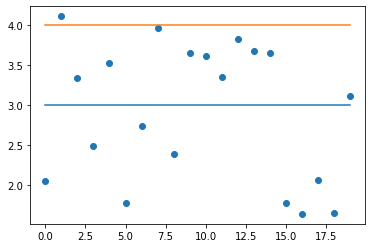

In [122]:
from asteroid.losses import singlesrc_neg_sisdr, singlesrc_neg_snr

total_steps = 2000
steps_til_summary = 1000
lr = 1e-4
# schedule = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, 100, T_mult=1, eta_min=lr / 1000, last_epoch=- 1, verbose=False)
# decay = torch.optim.lr_scheduler.StepLR(optim, total_steps, (1 / 1000) ** (1 / total_steps))

pesq = []
for wave in wavpath:
    bach_audio = AudioFile(wave)

    audio_siren = Siren(in_features=1, out_features=1, hidden_features=256, 
                        hidden_layers=3, first_omega_0=3000, outermost_linear=True)
    audio_siren.cuda()
    dataloader = DataLoader(bach_audio, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)
    
    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

    model_input, ground_truth, audio_siren = model_input.type(torch.float64), \
                                            ground_truth.type(torch.float64), \
                                             audio_siren.type(torch.float64)
    optim = torch.optim.Adam(lr=lr, params=audio_siren.parameters())
    decay = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=1/2**0.5, patience=20, verbose=False)
    # optim = torch.optim.AdamW(lr=1e-4, params=audio_siren.parameters())
    
    minloss = torch.inf
    with tqdm(range(total_steps)) as pbar:
        for step in pbar:
            optim.zero_grad()
            model_output, coords = audio_siren(model_input)    
            # loss = F.mse_loss(model_output, ground_truth)
            loss = singlesrc_neg_snr(model_output.squeeze(-1), ground_truth.squeeze(-1))
            
            pbar.set_postfix({'loss': loss.item()})

            loss.backward()
            optim.step()
            # schedule.step(step)
            decay.step(loss.item())
            if step > int(total_steps * 0.9) and minloss >= loss.item():
                minloss = loss.item()
                best = audio_siren.state_dict()
    
    audio_siren.load_state_dict(best)
    audio_siren.eval()
    with torch.no_grad():
        model_output, _ = audio_siren(model_input)
        
    model_output = model_output.float()
    ground_truth = ground_truth.float()
    torchaudio.save(os.path.join(datapath, 'SNR_recons' + os.path.basename(wave)), model_output.squeeze(-1).cpu().float(), sample_rate=rate)
    model_output = torchaudio.functional.resample(model_output.squeeze(-1), rate, 16000).squeeze().cpu()
    model_input = torchaudio.functional.resample(model_input.squeeze(-1), rate, 16000).squeeze().cpu()
    
    # model_output, _ = torchaudio.load(os.path.join(datapath, 'recons' + os.path.basename(wave)))
    model_output = model_output.squeeze().numpy()
    ground_truth = torchaudio.functional.resample(ground_truth.squeeze(-1), rate, 16000).squeeze().cpu()
    pesq.append(get_metrics(model_output, ground_truth.numpy(), model_output, sample_rate=16000, metrics_list=['pesq'])['pesq'])

print(max(pesq), min(pesq), np.mean(pesq))
plt.scatter(np.arange(len(pesq)), pesq)
plt.plot(np.ones_like(pesq) * 3)
plt.plot(np.ones_like(pesq) * 4)
print(pesq)